# 集成计算 case 3: 芯部输运


## 介绍

**FyTok** 用于执行集成计算。


In [1]:
import numpy as np
from spdm.view import sp_view

## 导入基准数据 （ITER 15MA）


In [2]:
from fytok.contexts.tokamak import Tokamak
from fytok.modules.core_profiles import CoreProfiles
from fytok.modules.equilibrium import Equilibrium
from spdm.core.expression import _x

2024-07-30 06:30:05,510 [    spdm]     INFO: 
########################################################################################################################
        ______      _____     _
       / ____/_  __|_   _|__ | | __
      / /_  / / / /  | |/ _ \| |/ /
     / __/ / /_/ /   | | (_) |   <
    /_/    \__, /    |_|\___/|_|\_\
          /____/

(C) 2021-2024 Zhi YU @ ASIPP. All rights reserved.
version: develop, spdm: develop, ontology: imas/3
########################################################################################################################

2024-07-30 06:30:05,639 [   fytok]  VERBOSE: Using ontology: imas/3 (dummy) at fytok/mappings/{schema}/imas/3:spdm/mapping/{schema}/imas/3


In [3]:
core_profiles_astra = CoreProfiles("file+iterprofiles://./data/profiles.xls#core_profiles")

core_profiles_1d_astra = core_profiles_astra.profiles_1d

equilibrium_astra = Equilibrium(f"file+geqdsk://./data/geqdsk.txt#equilibrium")

2024-07-30 06:30:06,069 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_iterprofiles
2024-07-30 06:30:06,242 [   fytok]  VERBOSE: Load module fytok.plugins.modules.equilibrium.fy_eq
2024-07-30 06:30:06,244 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_geqdsk


## 创建 Tokamak 实例


In [4]:
F = (1 - _x**2) ** 2

tokamak = Tokamak(
    device="iter",
    shot=900003,
    equilibrium=f"file+geqdsk://./data/geqdsk.txt#equilibrium",
    core_profiles={
        # fmt:off
        "profiles_1d": {
            "grid": {  "rho_tor_norm":np.linspace(0.001,0.995,128)},
            "electrons": {"temperature": 3.5e4 },
            "ion": [
                {"label":"D"     ,"density": 1.0e19, "temperature": 3.5e4 *F},
                {"label":"T"     ,"density": 1.0e19, "temperature": 3.5e4 *F},
                {"label":"He"    ,"density": 1.0e19, "temperature": 3.5e4 *F},
                {"label":"alpha" ,"density": 1.0e19, "temperature": 3.5e4 *F,"is_thermal":False},
            ],
        }
        # fmt:on
    },
    core_transport=[
        {"code": {"name": "predefined"}},
        # {"code": {"name": "fast_alpha"}},
    ],
    core_sources=[
        f"file+iterprofiles://./data/profiles.xls#core_sources/source/0",
        # {"code": {"name": "collisional_equipartition"}},
        # {
        #     "code": {
        #         "name": "fusion",
        #         "parameters": {"fusion_reactions": ["D(t,n)alpha"], "heating": True},
        #     }
        # },
        # {"code": {"name": "radiation"}},
        # {"code": {"name": "synchrotron_radiation"}},
    ],
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "discontinuity": [0.96, 0.995],
                "dc_pos": 0.96,
                "hyper_diff": 1.0e-5,
                "max_nodes": 512,
                "bc_tol": 1,
                "verbose": 2,
                "units": {
                    "psi_norm": 1,
                    "psi_norm_flux": -0.1,
                    "*/density": 1.0e19,
                    "*/density_flux": 1.0e23,
                    "*/temperature": 1.0e4,
                    "*/temperature_flux": 1.0e26,
                    # "ion/alpha/density": 1.0e14,
                    # "ion/alpha/density_flux": 1.0e16,
                    # "ion/He/density": 1.0e15,
                    # "ion/He/density_flux": 1.0e15,
                },
            },
        },
        "ion_thermal": ["D", "T"],  #
        "ion_non_thermal": ["alpha", "He"],
        "impurities": ["Ar", "Be"],
        "impurity_fraction": 0.02 * 4 + 0.0012 * 18,
        "boundary_condition_type": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            "psi_norm"                  : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*/density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*/temperature"             : 1,
            # fmt: on
        },
    },
)

2024-07-30 06:30:06,334 [   fytok]  VERBOSE: Load module spdm.plugins.data.file_xml


In [5]:
print(tokamak)

2024-07-30 06:30:06,767 [   fytok]  VERBOSE: Load module fytok.plugins.modules.transport_solver.fy_trans
2024-07-30 06:30:06,788 [   fytok]  VERBOSE: Load module fytok.plugins.modules.core_transport.model.predefined
------------------------------------------------------------------------------------------------------------------------
    Device: ITER, Shot: 900003, Run: 0,
    Run by Salmon on Salmon at 2024-07-30T06:30:06.843275, base on ontology "modified imas/3" 
------------------------------------------------------------------------------------------------------------------------
- Context           : fy_tok-develop
- Actors/Processors :
       core_sources : [dummy] 
   transport_solver : fy_trans-develop 
     core_transport : [predefined] 
- Components        : magnetics,pf_active,wall
------------------------------------------------------------------------------------------------------------------------



2024-07-30 06:30:06,856 [   fytok]  VERBOSE: Load module spdm.view.view_matplotlib
2024-07-30 06:30:06,941 [   fytok]  VERBOSE: Load module spdm.mesh.mesh_rectangular


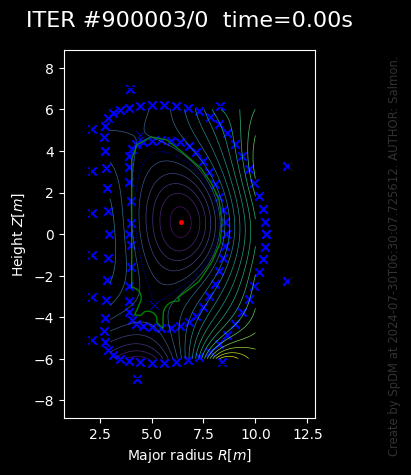

In [6]:
fig = sp_view.display(tokamak)

## 运行 Tokamak 实例


In [7]:
tokamak.refresh()

TypeError: 'ellipsis' object is not subscriptable

## 后处理


In [ ]:
core_profiles_1d = tokamak.core_profiles.profiles_1d